# MPlots
Jugando con los MatrixProfile & MPlots comenzando con el tutorial de Stumpy
https://stumpy.readthedocs.io/en/latest/Tutorial_The_Matrix_Profile.html

In [1]:
import numpy as np
import dvats.memory as mem
import dvats.mplots as mp

In [2]:
mps = mp.MatrixProfiles()

In [3]:
#Common
mps.data = np.random.rand(10000)
mps.subsequence_len = 50
print("Ts ~ ", mps.data.shape)
print("Expected mp length: ", int(np.floor(mps.data.shape[0]-mps.subsequence_len+1)))

Ts ~  (10000,)
Expected mp length:  9951


In [4]:
# Compute & Save Matrix Profile using both stumpy.stump & scamp
mps.compute('stump',  True, True, True)
print("Total MPs: ", len(mps.matrix_profiles))
print(mps.matrix_profiles[0])
mps.compute('scamp',  True, True, True)
print("Total MPs: ", len(mps.matrix_profiles))
print(mps.matrix_profiles[1])

Subsequence len:  50
--> matrix profile
--> Stump


/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 20 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


matrix profile 5.908829689025879 seconds -->
MPs | compute -> Subsequence len out:  50
MPs | compute -> Subsequence len inside:  50
Total MPs:  1
MP: [6.674483386622247 6.708178628243736 6.649679080874842 ...
 6.657356645651958 6.348108964416901 6.211486640735105]
Ids: [2597 2631 2632 ... 8657 8658 8659]
Ids_left: [-1 -1 -1 ... 8657 8658 8659]
Ids_right: [2597 2631 2632 ... -1 -1 -1]
Computation_time: 5.908829689025879
subsequence_len: 50
method: stump
Subsequence len:  50
--> matrix profile
--> Scamp
Check gpu use
True
matrix profile 0.3028407096862793 seconds -->
MPs | compute -> Subsequence len out:  50
MPs | compute -> Subsequence len inside:  50
Total MPs:  2
MP: [6.6744833 6.7081785 6.649679  ... 6.6573567 6.348109  6.2114863]
Ids: [2597 2631 2632 ... 8657 8658 8659]
Ids_left: []
Ids_right: []
Computation_time: 0.3028407096862793
subsequence_len: 50
method: scamp


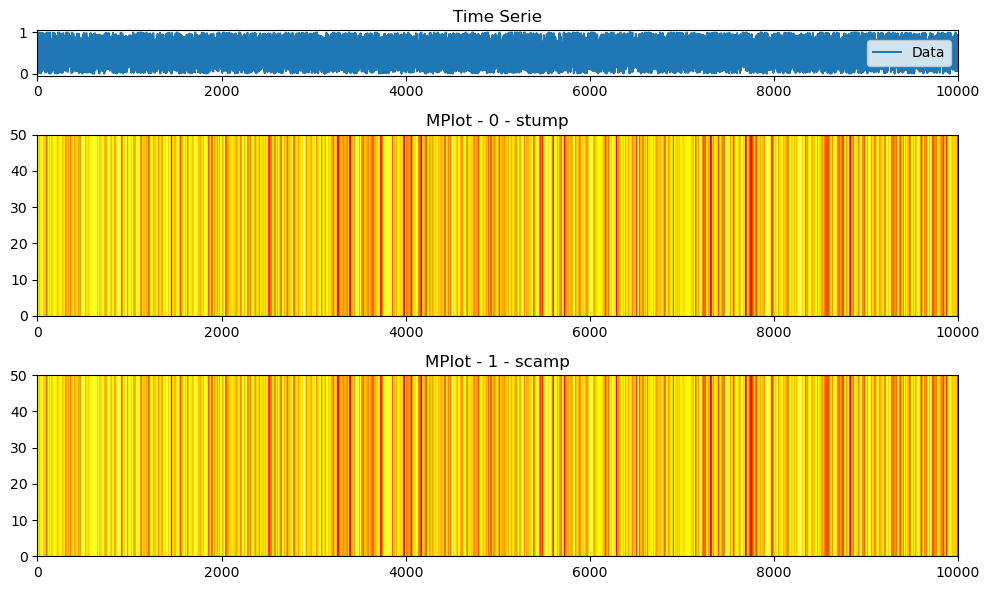

In [5]:
mps.plot([])

### Ejemplo de STUMPY Basics - Analyzing Motifs and Anomalies with STUMP and SCAMP
https://stumpy.readthedocs.io/en/latest/Tutorial_The_Matrix_Profile.html

In [6]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.patches import Rectangle
import datetime as dt

plt.style.use('https://raw.githubusercontent.com/TDAmeritrade/stumpy/main/docs/stumpy.mplstyle')

In [7]:
steam_df = pd.read_csv("https://zenodo.org/record/4273921/files/STUMPY_Basics_steamgen.csv?download=1")
steam_df.head()

,drum pressure,excess oxygen,water level,steam flow
0,320.08239,2.506774,0.032701,9.302970
1,321.71099,2.545908,0.284799,9.662621
2,320.91331,2.360562,0.203652,10.990955
3,325.00252,0.027054,0.326187,12.430107
4,326.65276,0.285649,0.753776,13.681666


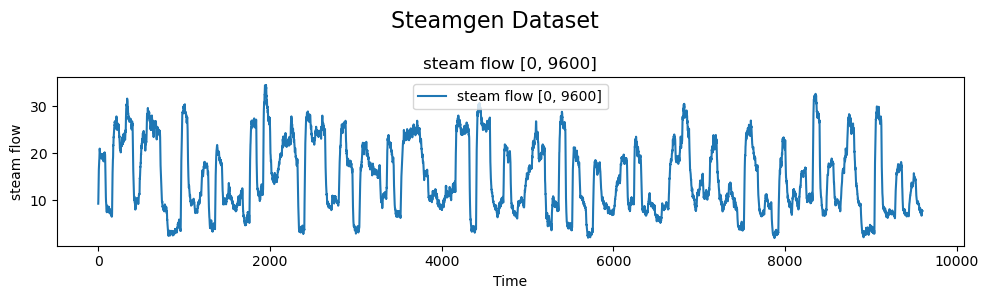

In [8]:
mp.plot_dataFrame('Steamgen Dataset', steam_df, [3])

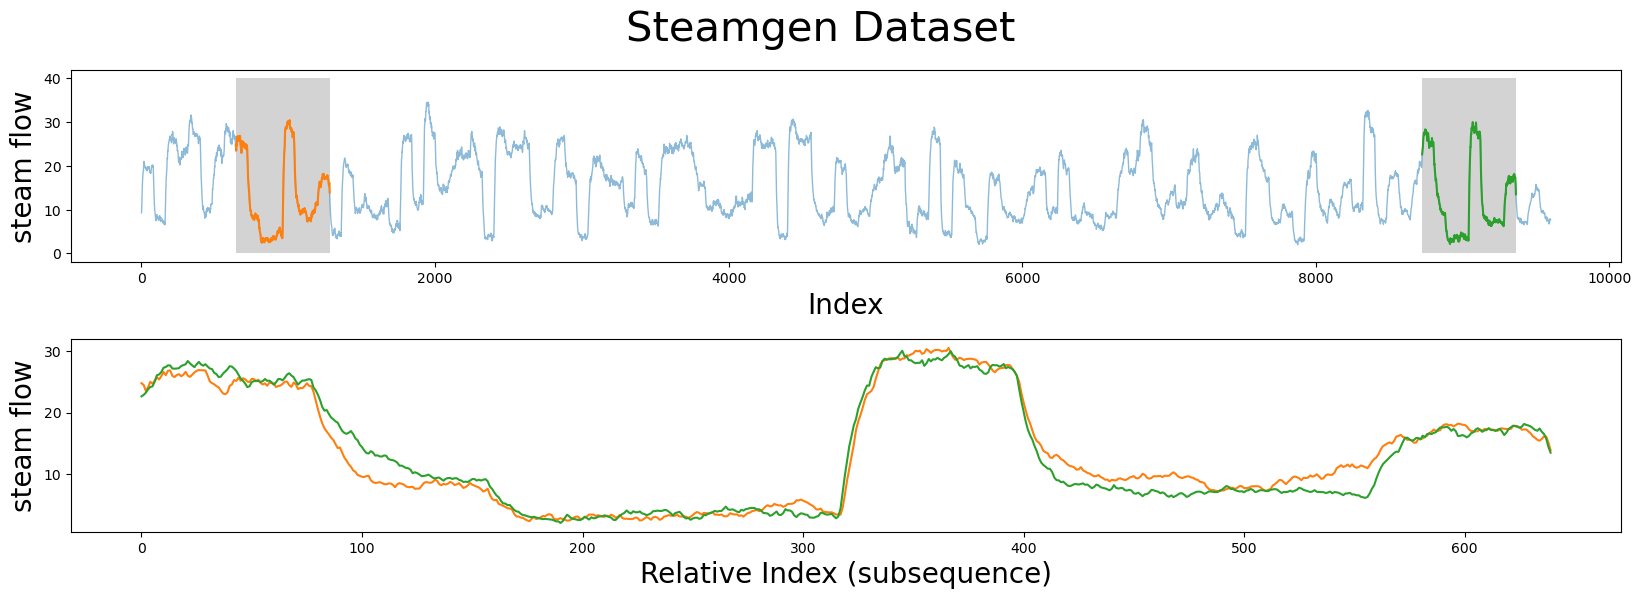

In [9]:
mp.plot_dataFrame_compareSubsequences('Steamgen Dataset', steam_df, 3, 640, 643, 8724)

In [10]:
steam_mps = mp.MatrixProfiles()
steam_mps.subsequence_len = 640
steam_mps.data = steam_df['steam flow']
steam_mps.compute('stump', print_flag = False, debug = False, timed = True)
steam_mps.compute('scamp', print_flag = False, debug = False, timed = True)

/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 18 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


MatrixProfile(matrix_profile=array([16.23541  , 16.081919 , 15.909404 , ...,  9.02293  ,  9.0382595,
        9.054692 ], dtype=float32), index=array([2242, 2243, 2245, ...,  877,  878,  879], dtype=int32), index_left=[], index_right=[], computation_time=0.11024713516235352, subsequence_len=640, method='scamp', motif_idx=0, nearest_neighbor_idx=0, nearest_neighbor_idx_left=0, nearest_neighbor_idx_right=0)

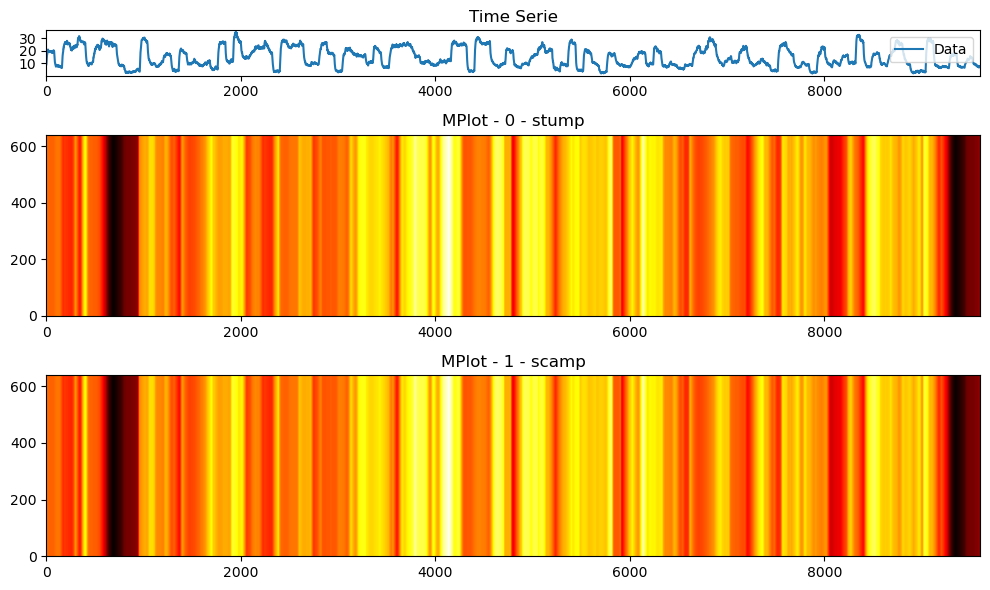

In [11]:
steam_mps.plot()

In [12]:
print("Ts ~ ", steam_mps.data.shape)
print("Expected mp length: ", int(np.floor(steam_mps.data.shape[0]-steam_mps.subsequence_len+1)))
print("mp_stumpy ~", steam_mps.matrix_profiles[0].matrix_profile.shape)
print("mp_scamp ~", steam_mps.matrix_profiles[1].matrix_profile.shape)
print(steam_mps.matrix_profiles[0])
print(steam_mps.matrix_profiles[1])

Ts ~  (9600,)
Expected mp length:  8961
mp_stumpy ~ (8961,)
mp_scamp ~ (8961,)
MP: [16.23541147724788 16.081918663230628 15.909403017873382 ...
 9.022931372214835 9.038259675949162 9.054692514421182]
Ids: [2242 2243 2245 ... 877 878 879]
Ids_left: [-1 -1 -1 ... 877 878 879]
Ids_right: [2242 2243 2245 ... -1 -1 -1]
Computation_time: 2.0510220527648926
subsequence_len: 640
method: stump
MP: [16.23541   16.081919  15.909404  ...  9.02293    9.0382595  9.054692 ]
Ids: [2242 2243 2245 ...  877  878  879]
Ids_left: []
Ids_right: []
Computation_time: 0.11024713516235352
subsequence_len: 640
method: scamp


In [13]:
stumpy_idxs = steam_mps.get_motif_idx(0)
scamp_idxs = steam_mps.get_motif_idx(1)

In [14]:
print(f"The motif (according to stumpy) is located at index {stumpy_idxs[0]}")
print(f"The motif (according to scamp) is located at index {scamp_idxs[0]}")

The motif (according to stumpy) is located at index 643
The motif (according to scamp) is located at index 8724


### --> Tiene sentido que haya salido diferente por tema de decimales... 
> ¿Serán vecinos?

In [15]:
print(f"The nearest neighbor (stumpy) is located at index {stumpy_idxs[1]}")
print(f"The nearest neighbor (scamp) is located at index {scamp_idxs[1]}")

The nearest neighbor (stumpy) is located at index 8724
The nearest neighbor (scamp) is located at index 643


¡Son los vecinos más cercanos en ambos casos!
De hecho, si imprimimos los valores, la z-distancia euclídea es la misma hasta donde podemos ver...

In [16]:
print( steam_mps.matrix_profiles[1].matrix_profile[stumpy_idxs[0]])
print( steam_mps.matrix_profiles[1].matrix_profile[stumpy_idxs[1]])
print( steam_mps.matrix_profiles[0].matrix_profile[scamp_idxs[0]])
print( steam_mps.matrix_profiles[0].matrix_profile[scamp_idxs[1]])

5.4916167
5.4916167
5.491619827769913
5.491619827769913


NameError: name 'mp' is not defined

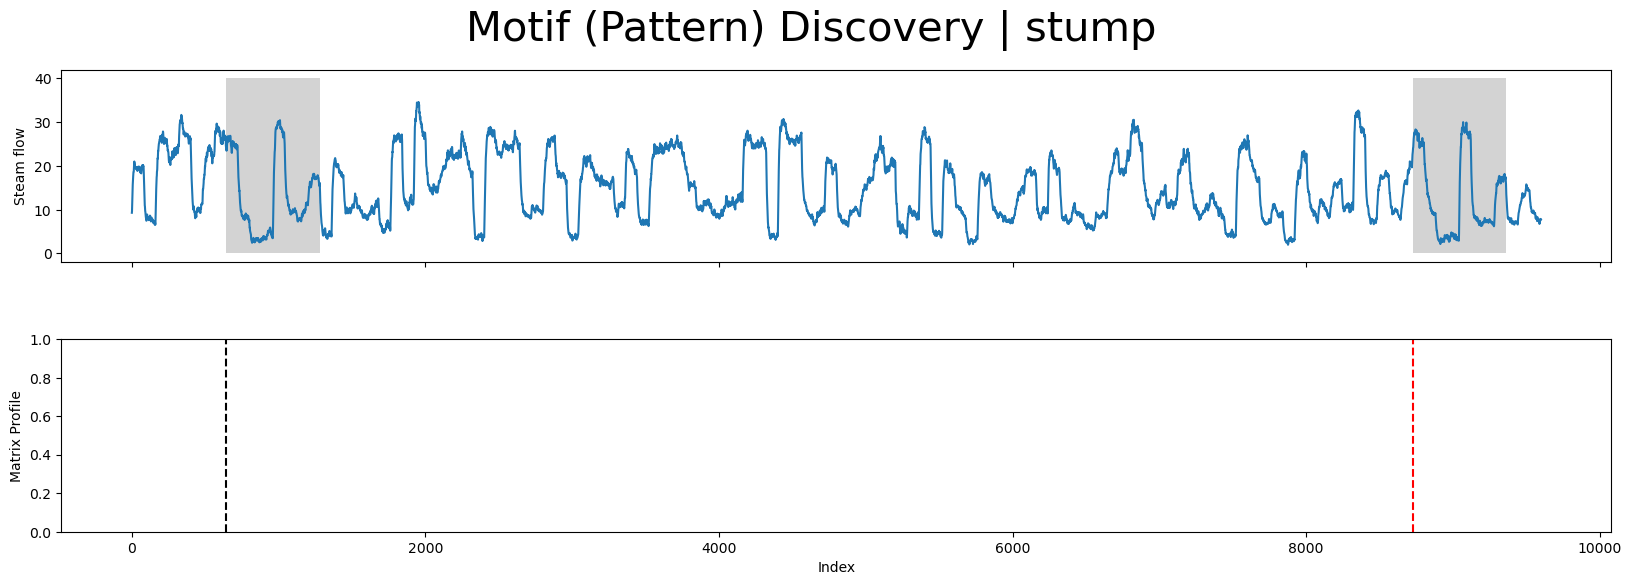

In [17]:
steam_mps.plot_motif('Steam flow', 0, stumpy_idxs[0], stumpy_idxs[1], '30', '10')

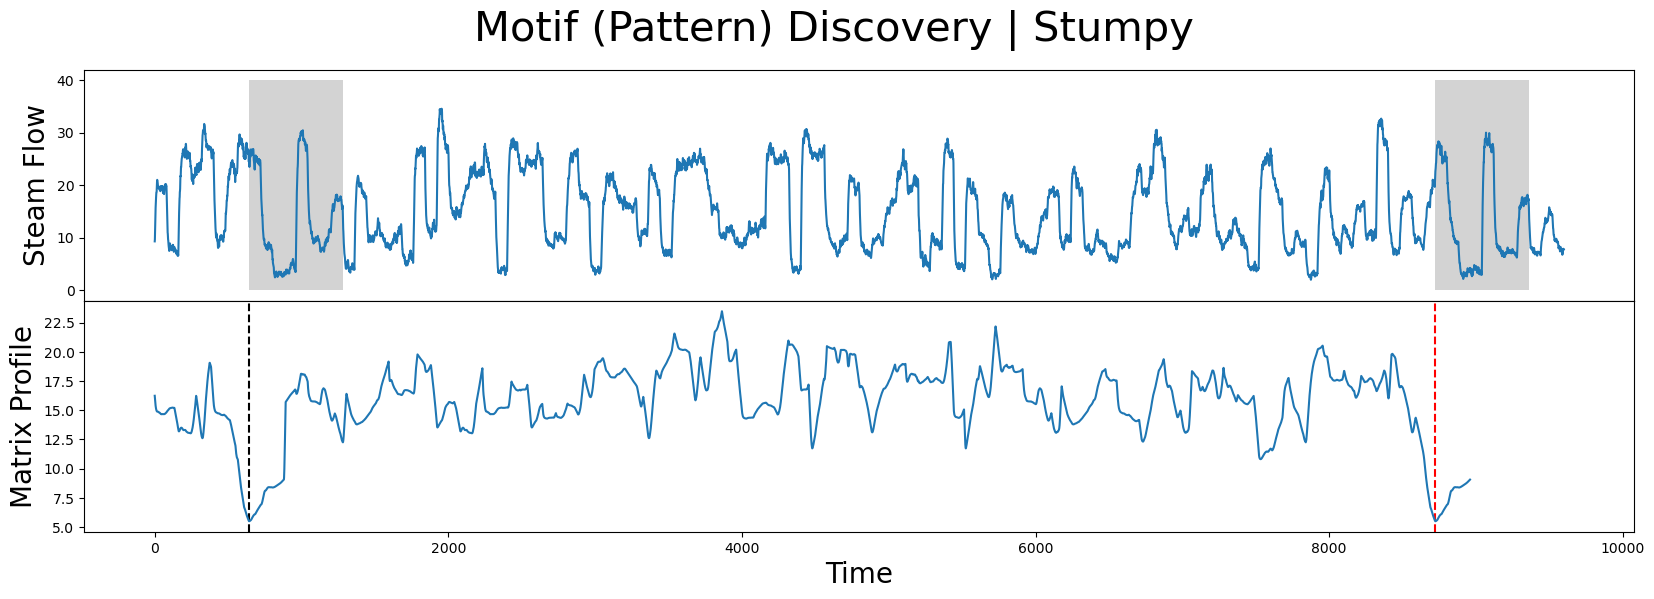

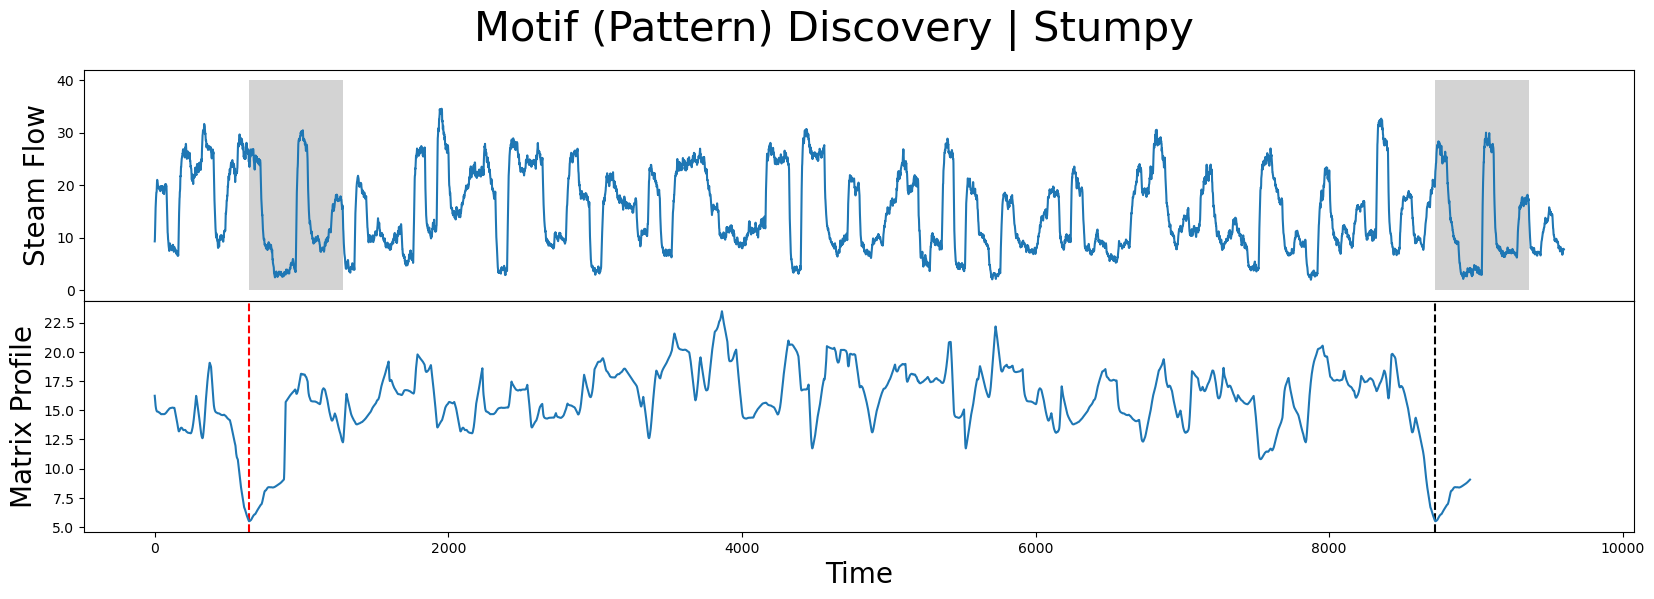

In [21]:
ts_name = 'Steam Flow'
def plt_motifs(ts, mp, ts_name, algorithm, motif_idx, nearest_neighbor_idx):
    fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
    plt.suptitle('Motif (Pattern) Discovery | ' + algorithm , fontsize='30')

    axs[0].plot(ts.values)
    axs[0].set_ylabel(ts_name, fontsize='20')
    rect = Rectangle((motif_idx, 0), m, 40, facecolor='lightgrey')
    axs[0].add_patch(rect)
    rect = Rectangle((nearest_neighbor_idx, 0), m, 40, facecolor='lightgrey')
    axs[0].add_patch(rect)
    axs[1].set_xlabel('Time', fontsize ='20')
    axs[1].set_ylabel('Matrix Profile', fontsize='20')
    axs[1].axvline(x=motif_idx, linestyle="dashed", color = "black")
    axs[1].axvline(x=nearest_neighbor_idx, linestyle="dashed", color="red")
    axs[1].plot(mp)
    plt.show()
plt_motifs(ts, mp_stumpy[:,0], ts_name, "Stumpy", motif_idx_stumpy, nearest_neighbor_idx_stumpy)
plt_motifs(ts, mp_scamp, ts_name, "Stumpy", motif_idx_scamp, nearest_neighbor_idx_scamp)

## Discord

In [22]:
discord_idx_stumpy = mp_stumpy_sorted[-1]
discord_idx_scamp = mp_scamp_sorted[-1]
print(f"Stumpy: The discord is located at index {discord_idx_scamp}")
print(f"Scamp: The discord is located at index {discord_idx_scamp}")

Stumpy: The discord is located at index 3864
Scamp: The discord is located at index 3864


In [23]:
print("Stumpy | Discord: ", mp_stumpy[discord_idx_stumpy])
print("Scamp |  Discord: [", 
      mp_scamp[discord_idx_scamp], index_scamp[discord_idx_scamp], "]")

Stumpy | Discord:  [23.476168367301856 4755 1864 4755]
Scamp |  Discord: [ 23.476168 4755 ]


The subsequence located at this global maximum is also referred to as a discord, novelty, or “potential anomaly”:

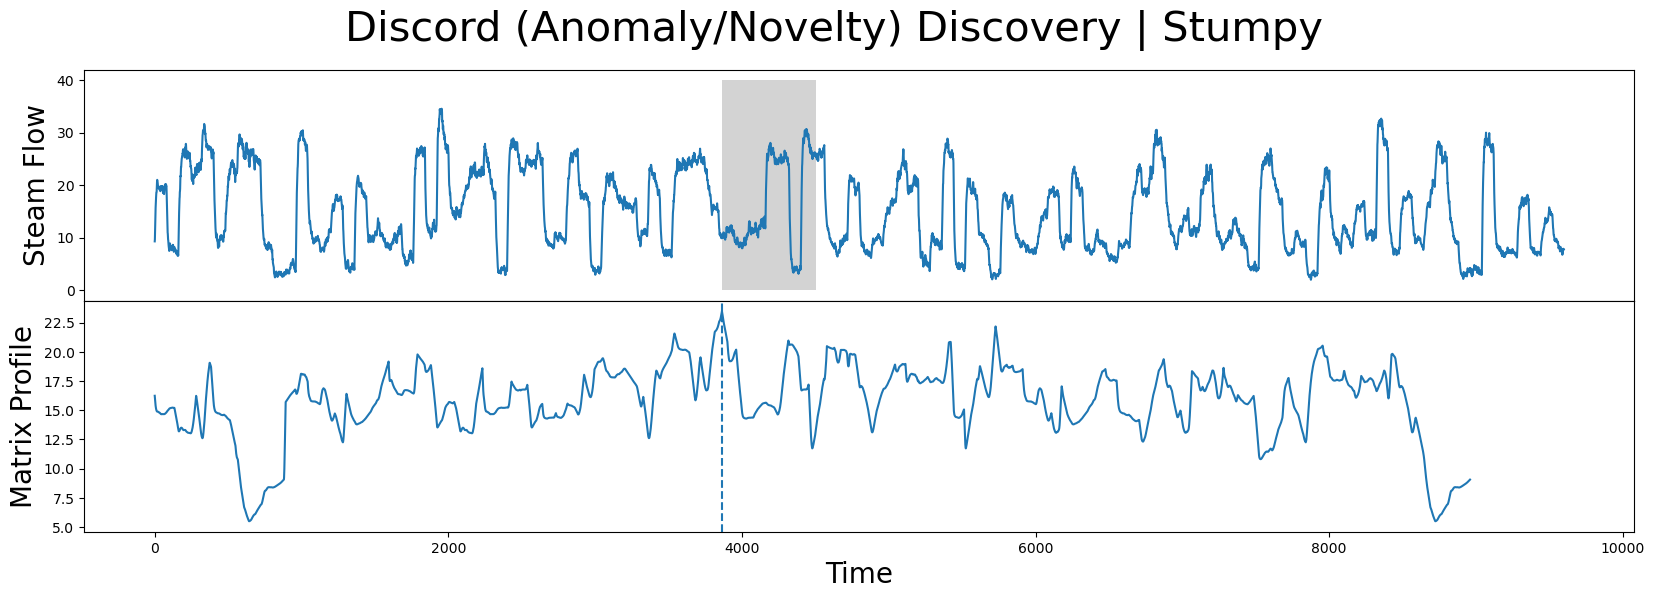

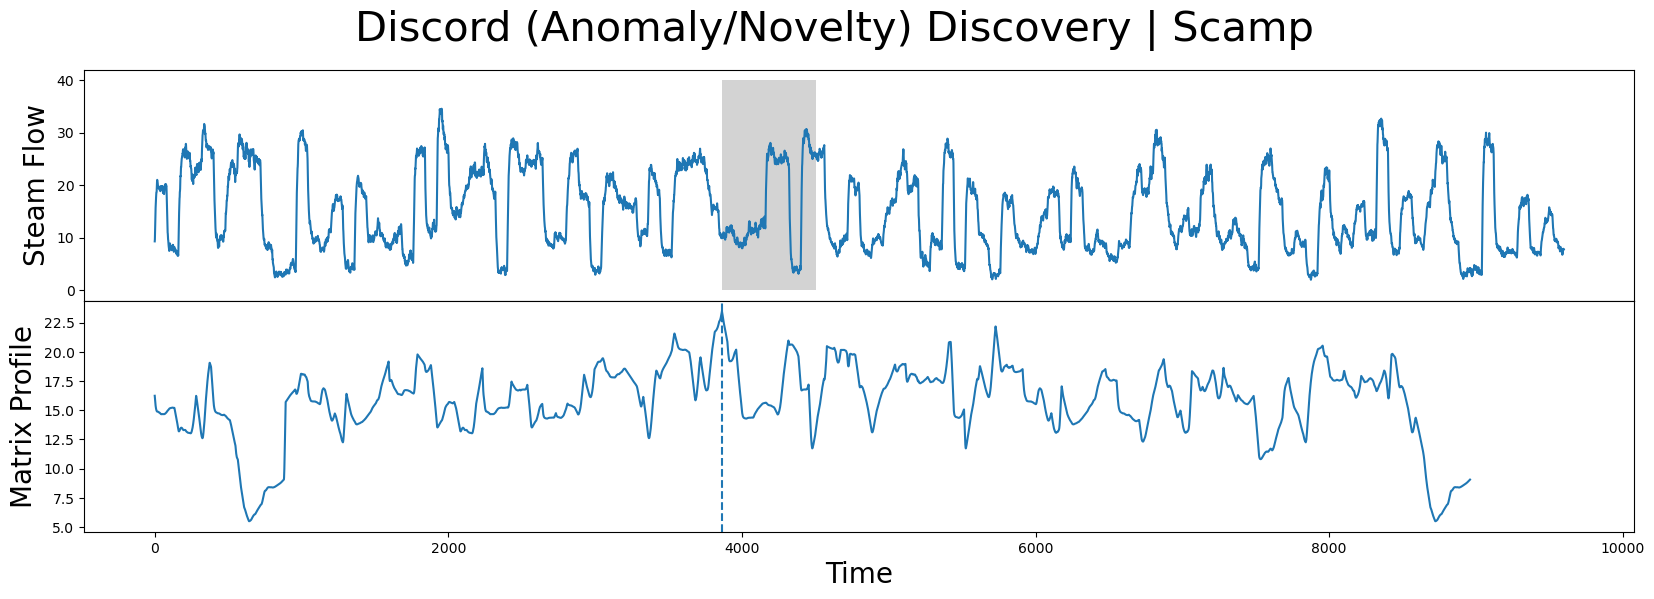

In [24]:
def plot_discord(ts, mp, ts_name, algorithm, discord_idx):
    fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
    plt.suptitle('Discord (Anomaly/Novelty) Discovery | '+ algorithm, fontsize='30')

    axs[0].plot(ts.values)
    axs[0].set_ylabel(ts_name, fontsize='20')
    rect = Rectangle((discord_idx, 0), m, 40, facecolor='lightgrey')
    axs[0].add_patch(rect)
    axs[1].set_xlabel('Time', fontsize ='20')
    axs[1].set_ylabel('Matrix Profile', fontsize='20')
    axs[1].axvline(x=discord_idx, linestyle="dashed")
    axs[1].plot(mp)
    plt.show()
plot_discord(ts, mp_stumpy[:,0], ts_name, "Stumpy", discord_idx_stumpy)
plot_discord(ts, mp_scamp, ts_name, "Scamp", discord_idx_scamp)

Intentando ver la matriz Distance Profile al completo

In [25]:
steam_flow = steam_df['steam flow'].values
#No nans
steam_flow = [ 0 if np.isnan(x) else x for x in steam_flow ]

Cogiendo Distance Matrix al completo

In [26]:
m = 640

In [27]:
steam_flow = steam_df['steam flow'].values
#No nans
steam_flow = [ 0 if np.isnan(x) else x for x in steam_flow ]

In [28]:
n = len(steam_flow) 
subsequence_len = m
print("Expected: ", len(steam_flow) - m + 1)

Expected:  8961


In [29]:
MPlot_matrix_stumpy = np.empty((n - m + 1, n - m + 1))
MPlot_matrix_scamp = np.empty((n - m + 1, n - m + 1))

In [30]:
reference_idx = np.random.randint(low=0, high=len(steam_flow) - m)
reference_subseq = steam_flow[reference_idx:reference_idx + m]

In [31]:
# Calcular el Distance Profile para cada subsecuencia en la serie temporal
distance_matrix_stumpy = np.array([
    stump.core.mass(reference_subseq, steam_flow[i:i + m]) 
    for i in range(len(steam_flow) - m + 1)
])

distance_matrix_scamp = np.array([
    scamp.abjoin(reference_subseq, steam_flow[i:i + m], m)[0]
    for i in range(len(steam_flow) - m + 1)
])

In [32]:
print(len(steam_flow))
print(distance_matrix_stumpy.shape)
print(distance_matrix_scamp.shape)
print(MPlot_matrix_stumpy.shape)
print(MPlot_matrix_scamp.shape)

9600
(8961, 1)
(8961, 1)
(8961, 8961)
(8961, 8961)


In [37]:
#import torch
#torch.cuda.set_device(0)

In [39]:
#Calculamos el MPlot
for i in range(n - m + 1):
    ### Calculamos el Distance Profile utilizando el algoritmo MASS / Scamp
    MPlot_matrix_stumpy[i,:] = stump.core.mass(steam_flow[i:i + m], steam_flow)

In [47]:
print(n)
steam_flow

9600


[9.3029701,
 9.6626206,
 10.990955,
 12.430107,
 13.681666,
 14.608885999999998,
 15.7132,
 16.536307,
 17.025369,
 17.61613,
 18.101964,
 18.617838,
 18.635723,
 18.751322,
 19.508894,
 20.456632,
 20.896455,
 21.027555,
 20.836174,
 20.700635,
 20.394276,
 20.221607,
 19.741009,
 19.849174,
 19.753394,
 19.77857,
 19.799859,
 19.439141,
 19.584162,
 19.499002,
 19.649351,
 19.328394,
 19.169509,
 19.235623,
 19.278401,
 19.340028,
 19.342076,
 19.112734,
 18.867467,
 19.073703,
 19.238704,
 19.330707,
 19.74182,
 19.829021,
 19.73419,
 19.722264000000003,
 19.838407,
 19.686409,
 19.420519,
 19.458585,
 19.388755,
 19.331936,
 19.706821,
 19.818001,
 19.503039,
 18.989663,
 18.621073000000003,
 18.534034,
 18.593332,
 18.664088,
 18.542793,
 18.38165,
 18.366319,
 18.358475,
 18.310149,
 18.671321,
 19.095534,
 19.519949,
 19.652749,
 19.952451,
 20.146499,
 19.887907,
 19.82438,
 19.962698,
 20.110549,
 20.095481,
 20.207923,
 20.001645,
 20.070029,
 19.7414,
 19.751994,
 18.594969,

In [42]:
n-m+1

8961

In [44]:
m

640

In [40]:
def plot_mp(ts, ts_name, MPlot_matrix, algorithm):
    fig = plt.figure(figsize=(10, 10))
    gs = GridSpec(2, 1, height_ratios=[1, 4])

    # Serie temporal
    ax1 = fig.add_subplot(gs[0])
    ax1.plot(ts, label="Serie Temporal")
    ax1.set_title(ts_name + " | " +  algorithm)
    ax1.legend()

    # MPlot
    ax2 = fig.add_subplot(gs[1], sharex=ax1)
    # Utilizar 'imshow' para visualizar la matriz MPlot
    ax2.imshow(MPlot_matrix, aspect='auto', origin='lower', cmap='hot', extent=(0, len(ts) - m, 0, len(ts) - m))
    ax2.set_title("MPlot")
    ax2.set_xlabel('Subsecuencia Inicial')
    ax2.set_ylabel('Subsecuencia Referencia')

    plt.tight_layout()
    plt.show()

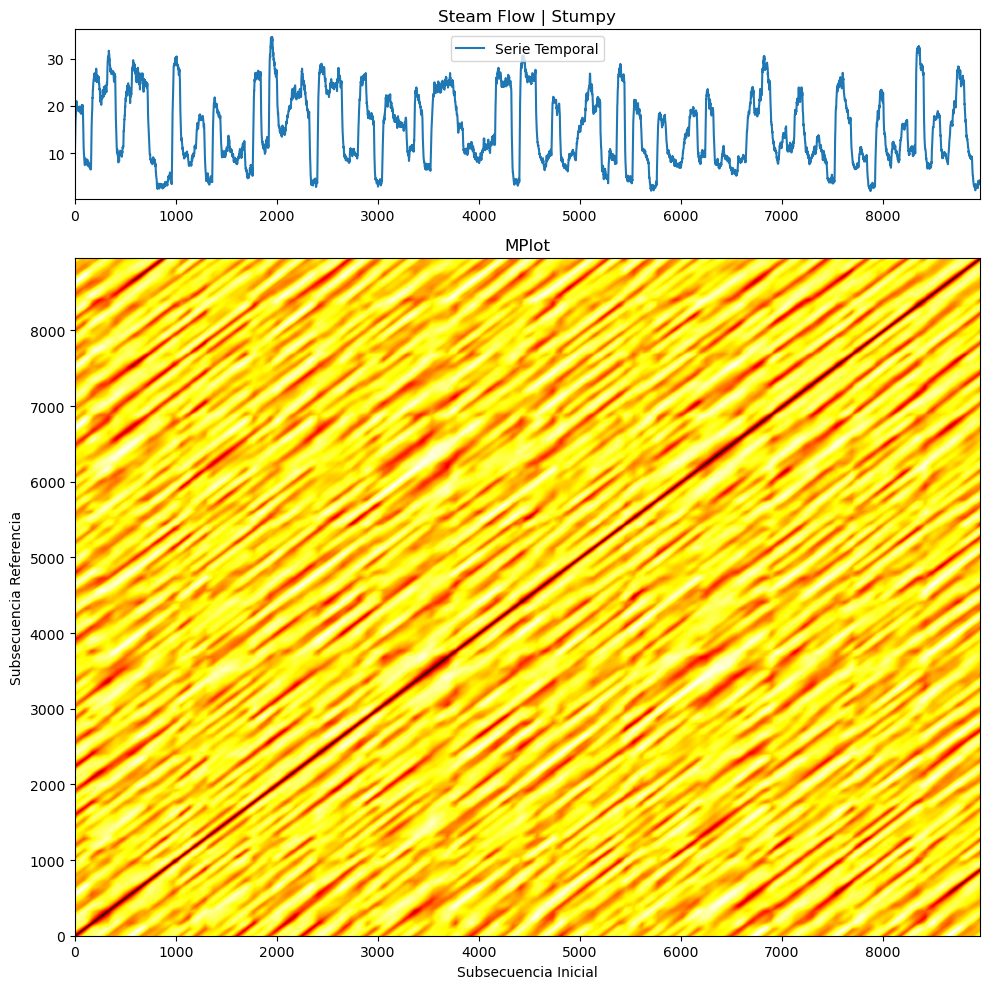

In [41]:
plot_mp(steam_flow, ts_name, MPlot_matrix_stumpy, "Stumpy")

In [ ]:
mp_scamp, _ = scamp.selfjoin(ts, m)

In [ ]:
mp_scamp.shape

In [ ]:
#https://scamp-docs.readthedocs.io/en/latest/pyscamp/_generate/pyscamp.selfjoin_matrix.htm

In [ ]:
ts.shape

In [ ]:
MPlot_matrix_stumpy.shape

In [ ]:
MPlot_matrix_stumpy

In [ ]:
print(np.isnan(steam_flow).any())

In [ ]:
# MPlot_matrix_stumpy[i,:] = stump.core.mass(steam_flow[i:i + m], steam_flow)
MPlot_matrix_scamp = scamp.selfjoin_matrix(
    steam_flow, 
    m, 
    gpus=[],
    mheight = n - m + 1, 
    mwidth = n - m + 1,
    verbose = True,
    pearson = False
)

In [ ]:
MPlot_matrix_scamp.shape

In [ ]:
MPlot_matrix_scamp

In [ ]:
plot_mp(steam_flow, ts_name, MPlot_matrix_scamp, "Scamp")